In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
from config import config

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("data/final.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
tst_size=20
trn, tst = data[:-tst_size], data[-tst_size:]

In [3]:
statefulLSTM = torch.load('./modelpth/Stateful/Stateful_AdamW_epochs_50_hidden_size_64_batch_size_128.pth')
statefulParam = config['Stateful']['model_params']

In [4]:
statefullstm = StatefulLoadData(data,tst_size)
state_trn_scaled, state_tst_scaled = statefullstm.scaling()
trn_x = torch.tensor(state_trn_scaled[:-1]).split(config['Stateful']['model_params']['state_batch_size'])
trn_y = torch.tensor(state_trn_scaled[1:]).split(config['Stateful']['model_params']['state_batch_size'])
tst_y = torch.tensor(state_tst_scaled)

In [7]:
len(trn_y)

14

In [5]:
trn_y = trn_y[0]
trn_y = trn_y.reshape(-1,2)
trn_y = trn_y[-1]

In [6]:
statefulLSTM.eval()
with torch.inference_mode():
    p = statefulLSTM.predict(trn_y.to(device), len(tst_y))
    #tst_loss = F.mse_loss(p, tst_y.to(device)).item()

In [7]:
print(p)

tensor([[0.7529, 0.8552],
        [0.7351, 0.8296],
        [0.7224, 0.8073],
        [0.7144, 0.7905],
        [0.7102, 0.7797],
        [0.7086, 0.7740],
        [0.7087, 0.7721],
        [0.7098, 0.7729],
        [0.7114, 0.7751],
        [0.7133, 0.7781],
        [0.7153, 0.7815],
        [0.7174, 0.7850],
        [0.7194, 0.7886],
        [0.7215, 0.7920],
        [0.7235, 0.7955],
        [0.7255, 0.7988],
        [0.7274, 0.8020],
        [0.7294, 0.8052],
        [0.7313, 0.8083],
        [0.7332, 0.8113]])


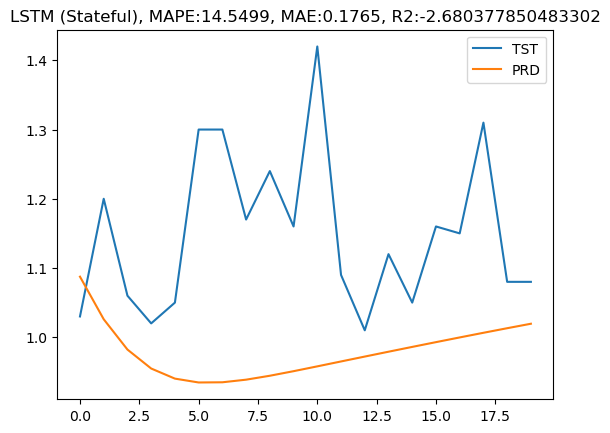

In [8]:
scaler = statefullstm.get_scaler()
prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()